### データの確認

（1）　会員データ（customers.csv）の確認

In [1]:
import pandas as pd
cust_df = pd.read_csv('customers.csv')
cust_df

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0
...,...,...,...
4995,4996,age50~,freq0
4996,4997,age50~,freq0
4997,4998,age35~49,freq1
4998,4999,age50~,freq1


In [2]:
ages = cust_df['age_cat'].unique()

In [3]:
freqs = cust_df['freq_cat'].unique()

<AxesSubplot:>

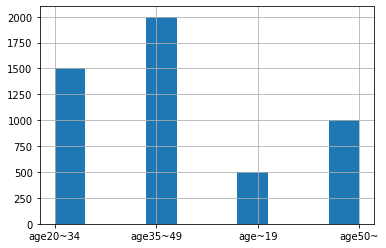

In [4]:
cust_df['age_cat'].hist()

<AxesSubplot:>

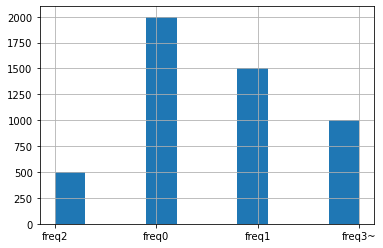

In [5]:
cust_df['freq_cat'].hist()

In [6]:
cust_pivot_df = pd.pivot_table(data=cust_df, values='customer_id', columns='freq_cat', index='age_cat', aggfunc='count')
cust_pivot_df = cust_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
cust_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


<AxesSubplot:xlabel='freq_cat', ylabel='age_cat'>

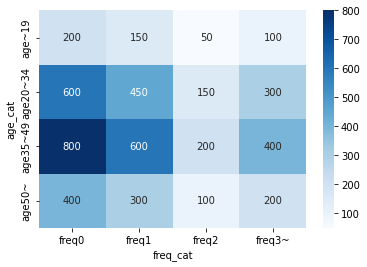

In [7]:
import seaborn as sns
sns.heatmap(cust_pivot_df, annot=True, fmt='d', cmap='Blues')

In [8]:
prob_df = pd.read_csv('visit_probability.csv')
prob_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


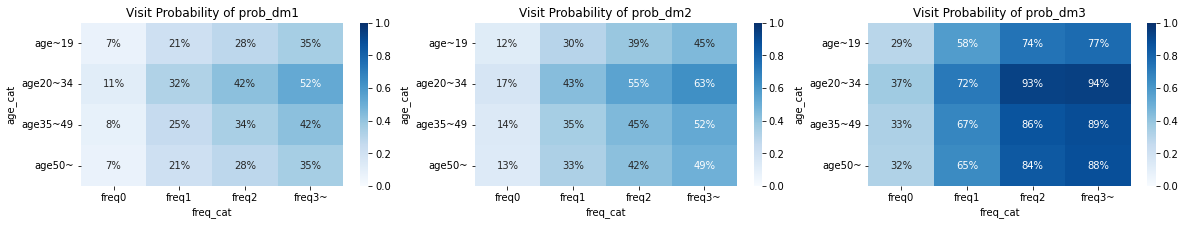

In [9]:
import matplotlib.pyplot as plt
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1,3, figsize=(20,3))
for i, ptn in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    prob_pivot_df = pd.pivot_table(data=prob_df, values=ptn, columns='freq_cat', index='age_cat')
    prob_pivot_df = prob_pivot_df.reindex (['age~19','age20~34', 'age35~49', 'age50~'])
    sns.heatmap(prob_pivot_df, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=ax[i])
    ax[i].set_title(f'Visit Probability of {ptn}')
plt.show()

### モデリング1：会員個別送付モデル

In [10]:
from mip import *

m = Model()

要件（1）　各会員に対してどのパターンのダイレクトメールを送付するかを決定

In [11]:
I = cust_df['customer_id'].tolist()
M = [1, 2, 3]

In [12]:
x = m.add_var(name='', var_type=BINARY)

In [19]:
# （1）各会員に対してどのパターンのダイレクトメールを送付するかを決定するための変数を用意
xim = {}
for i in I:
    for mm in M:
        xim[i,mm] = m.add_var(name=f'xim({i},{mm})', var_type=BINARY)
# 決定変数の数
len(xim)

15000

要件（2）　送付できるのは1 パターンのみ

In [20]:
for i in I:
        m += xsum(xim[i,mm] for mm in M) == 1

要件（3）　クーポン付与による来客増加数を最大化

In [24]:
keys = ['age_cat', 'freq_cat']
cust_prob_df = pd.merge(cust_df, prob_df)#, on=keys) -> keysをキーとして結合処理をする
cust_prob_df

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93
...,...,...,...,...,...,...,...
4995,4474,age~19,freq2,3,0.28,0.39,0.74
4996,4596,age~19,freq2,3,0.28,0.39,0.74
4997,4720,age~19,freq2,3,0.28,0.39,0.74
4998,4910,age~19,freq2,3,0.28,0.39,0.74


In [33]:
cust_prob_ver_df = cust_prob_df.rename(columns={'prob_dm1': 1, 'prob_dm2': 2, 'prob_dm3': 3})\
                  .melt(id_vars=['customer_id'], value_vars=[1,2,3], var_name='dm', value_name='prob')
cust_prob_ver_df

,customer_id,dm,prob
0,1,1,0.42
1,199,1,0.42
2,200,1,0.42
3,255,1,0.42
4,269,1,0.42
...,...,...,...
14995,4474,3,0.74
14996,4596,3,0.74
14997,4720,3,0.74
14998,4910,3,0.74


In [34]:
Pim = cust_prob_ver_df.set_index(['customer_id','dm'])['prob'].to_dict()

In [35]:
cust_prob_ver_df.set_index(['customer_id','dm'])['prob']

customer_id  dm
1            1     0.42
199          1     0.42
200          1     0.42
255          1     0.42
269          1     0.42
                   ... 
4474         3     0.74
4596         3     0.74
4720         3     0.74
4910         3     0.74
4947         3     0.74
Name: prob, Length: 15000, dtype: float64

In [36]:
# （3）クーポン付与による来客増加数を最大化
m += xsum((Pim[i,mm] - Pim[i,1]) * xim[i,mm] for i in I for mm in [2,3])

要件（4）　会員の予算消費期待値の合計は100 万円以下

In [44]:
Cm = {1:0, 2:1000, 3:2000}

# （4）顧客の消費する費用の期待値の合計は100万円以下
m += xsum(Cm[mm] * Pim[i,mm]* xim[i,mm] for i in I for mm in [2,3]) <= 1000000

# セグメントのリスト
S = prob_df['segment_id'].to_list()
print(f'S = {S}')

# 各セグメントとそのセグメントに属する顧客数を対応させる辞書の作成
Ns = cust_prob_df.groupby('segment_id')['customer_id'].count().to_dict()
print(f'Ns = {Ns}')

# 会員をキーとして属するセグメントを返す辞書
Si = cust_prob_df.set_index('customer_id')['segment_id'].to_dict()
#print(f'Si = {Si}')

S = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Ns = {1: 200, 2: 150, 3: 50, 4: 100, 5: 600, 6: 450, 7: 150, 8: 300, 9: 800, 10: 600, 11: 200, 12: 400, 13: 400, 14: 300, 15: 100, 16: 200}
